In [35]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import dataloader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision.datasets as datasets
from tqdm import tqdm

In [36]:
class Discriminator(nn.Module):
    def __init__(self,inch,features):
        super().__init__()
        #((n-f+2p)/s)+1
        self.dis= nn.Sequential(
            nn.Conv2d(inch,features,kernel_size=4,stride=2,padding=1),
            nn.LeakyReLU(0.2),
            self.convblock(features,features*2,kernel_size=4,stride=2,padding=1),
            self.convblock(features*2,features*4,kernel_size=4,stride=2,padding=1),
            self.convblock(features*4,features*8,kernel_size=4,stride=2,padding=1),
            nn.Conv2d(features*8,1,kernel_size=4,stride=2,padding=0),


        )

    def convblock(self,in_channels,out_channels,kernel_size,stride,padding):
        block= nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,bias=False),
            #nn.BatchNorm2d(out_channels),
            nn.InstanceNorm2d(out_channels, affine=True), #acc to paper
            nn.LeakyReLU(0.2),
        )

        return block

    def forward(self,x):
      return self.dis(x)

class Generator(nn.Module):

    def __init__(self,zdim,otch,features):
        super().__init__()
        #((n-f+2p)/s)+1
        self.enc= nn.Sequential(

            self.convTblock(zdim,features*16,4,1,0),
            self.convTblock(features*16,features*8,4,2,1),
            self.convTblock(features*8,features*4,4,2,1),
            self.convTblock(features*4,features*2,4,2,1),
            nn.ConvTranspose2d(features*2,otch,kernel_size=4,stride=2,padding=1),
            nn.Tanh(),
        )

    def convTblock(self,in_channels,out_channels,kernel_size,stride,padding):
        block= nn.Sequential(
            nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        return block

    def forward(self,x):
      return self.enc(x)

In [37]:
def weightsinit(model):
  for m in model.modules():
    if isinstance(m,(nn.Conv2d,nn.ConvTranspose2d, nn.BatchNorm2d)):
      nn.init.normal_(m.weight.data,0.0,0.02)

In [38]:
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr=1e-4
noisedim=100
imagedim=64
chan=1

crit_it=5
features=16
batchsize=64
epochs=5
LAMBDA=10
#clip=0.01

In [39]:
disc= Discriminator(chan,features).to(device)
gen= Generator(noisedim,chan,features).to(device)

weightsinit(disc)
weightsinit(gen)


opt_disc= optim.Adam(disc.parameters(),lr=lr,betas=(0.0,0.9))
opt_gen= optim.Adam(gen.parameters(),lr=lr,betas=(0.0,0.9))


fixednoise=torch.randn(32,noisedim,1,1).to(device)

transform= transforms.Compose([
    transforms.Resize((imagedim,imagedim)),
    transforms.ToTensor(),
    transforms.Normalize([(0.5) for _ in range(chan)],[(0.5) for _ in range(chan)])
])
dataset= datasets.MNIST(root='mnist/',train=True,transform=transform,download=True)
dataloader= torch.utils.data.DataLoader(dataset,batch_size=batchsize,shuffle=True)


In [40]:
len(dataloader)

938

In [41]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [60]:
def grad_penalty(real,fake,disc):
  batch,c,h,w= real.shape
  eps=torch.randn((batch,1,1,1)).repeat(1,c,h,w).to(device)

  ip=real*eps +(1-eps)*fake

  disc_ip=disc(ip)

  grads=torch.autograd.grad(
      outputs=disc_ip,
      inputs=ip,
      grad_outputs=torch.ones_like(disc_ip),
      create_graph=True,
      retain_graph=True
  )[0]

  grads=grads.view(grads.shape[0],-1)
  grad_norm=grads.norm(2,dim=1)
  penalty=torch.mean((grad_norm-1)**2)
  return penalty


In [43]:
from tqdm import tqdm

In [ ]:
lossDacg=0
lossGacg=0
epochs=2
for epoch in range(epochs):
  loop=tqdm(enumerate(dataloader))

  for (bid,(img,_)) in loop:

    #Discriminator training
    real=img.to(device)



    for _ in range(crit_it):
      noise= torch.randn(batchsize,noisedim,1,1).to(device)
      disc_real=disc(real).reshape(-1)
      fake= gen(noise)
      disc_fake=disc(fake).reshape(-1)

      gp=grad_penalty(real,fake,disc)
      lossC= (-(torch.mean(disc_real) - torch.mean(disc_fake)) + gp*LAMBDA)
      lossDacg+=lossC.item()

      disc.zero_grad()
      lossC.backward(retain_graph=True)
      opt_disc.step()

      #for weight clipping
      """for p in disc.parameters():
        p.data.clamp_(-clip,clip)"""

    #Generator Training

    out=disc(fake).reshape(-1)
    lossG= (-torch.mean(out))
    lossGacg+=lossG.item()

    gen.zero_grad()
    lossG.backward()
    opt_gen.step()

    loop.set_postfix({'lossD': lossC.item(),'lossG': lossG.item()})
    #print(bid)

    if bid==0:
      print(f'Epoch {epoch} Loss D: {lossDacg/((epoch+1) * len(dataloader))} Loss G: {lossGacg/((epoch+1) * len(dataloader))}')
      lossDacg=0
      lossGacg=0

      with torch.no_grad():
        maker=gen(fixednoise)

        img_grid_fake= torchvision.utils.make_grid(maker,normalize=True)
        img_grid_real= torchvision.utils.make_grid(real[:32],normalize=True)

        show([img_grid_fake,img_grid_real])


In [ ]:
torch.save(disc.state_dict(),'disc_DCGAN.pth')
torch.save(gen.state_dict(),'gen_DCGAN.pth')

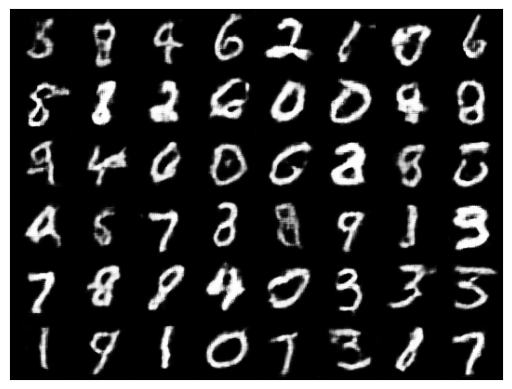

In [63]:
random= torch.randn(48,noisedim,1,1).to(device)
fake= gen(random)
img_grid_fake= torchvision.utils.make_grid(fake,normalize=True)
show(img_grid_fake)